Importante: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7

In [110]:
from __future__ import absolute_import, division, print_function

import pathlib

import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [111]:
df = pd.read_excel('SSG_Cobem_Outlires_Removed_5.xlsx')
df.tail()

,Coal_flow,Total_primary_air_flow,Total_secondary_air_flow,Oxygen_out_boiler,Gas_flow_boiler,Steam_flow
3882,134.478854,75.904406,240.745798,1.456214,376.668920,1182.739570
3883,134.938221,75.781893,240.163285,1.393499,376.422644,1184.445759
3884,134.970703,75.994680,240.691500,1.375072,378.305897,1185.892578
3885,134.407482,75.849424,241.232099,1.340046,377.729343,1185.412553
3886,134.393916,76.014896,241.736848,1.329290,377.429762,1185.857300


In [31]:
df.isna().sum()

Coal_flow                   0
Total_primary_air_flow      0
Total_secondary_air_flow    0
Oxygen_out_boiler           0
Gas_flow_boiler             0
Steam_flow                  0
dtype: int64

In [33]:
df = df.dropna()

In [112]:
new_df=df.drop_duplicates(subset='Steam_flow', keep='first', inplace=False)
new_df.shape

(3732, 6)

In [113]:
train_dataset = new_df.sample(frac=0.8,random_state=0)
test_dataset = new_df.drop(train_dataset.index)

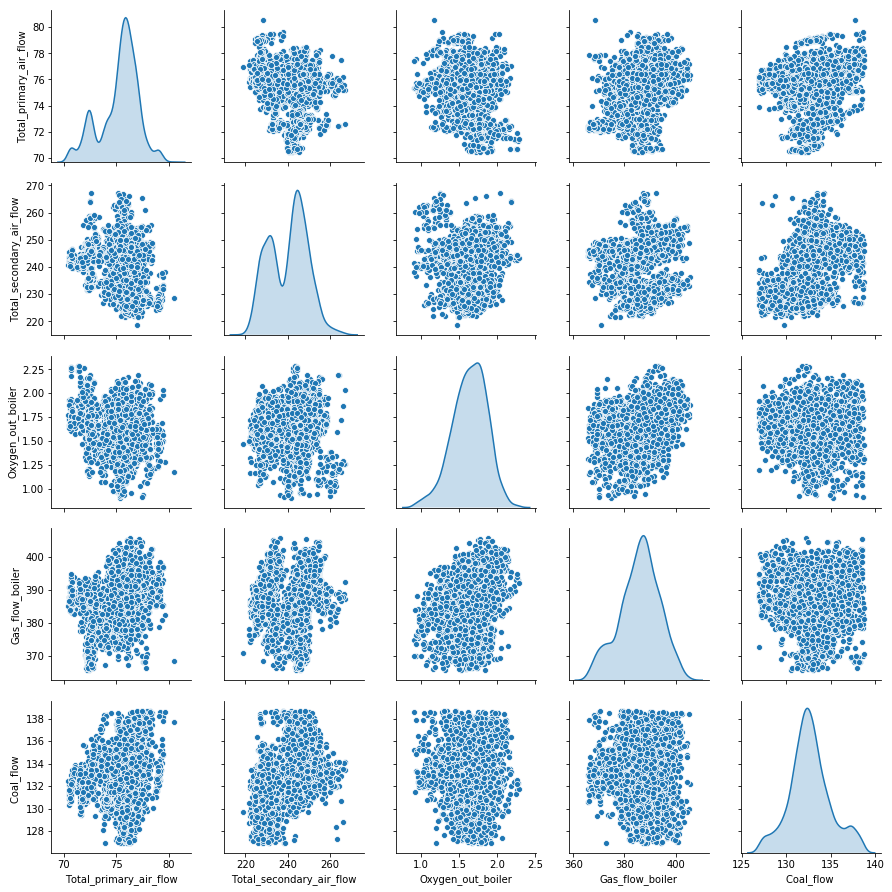

In [114]:
sns.pairplot(train_dataset[["Total_primary_air_flow", "Total_secondary_air_flow", "Oxygen_out_boiler", "Gas_flow_boiler", "Coal_flow "]], diag_kind="kde")

In [115]:
train_stats = train_dataset.describe()
train_stats.pop("Steam_flow")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Coal_flow,2986.0,132.684995,2.300494,126.932574,131.332425,132.536129,133.936491,138.686495
Total_primary_air_flow,2986.0,75.314166,1.826481,70.447487,74.362684,75.700616,76.495085,80.513746
Total_secondary_air_flow,2986.0,240.371966,9.107326,218.635106,232.130552,242.337119,247.118991,267.239128
Oxygen_out_boiler,2986.0,1.644530,0.226799,0.910780,1.494659,1.659043,1.807730,2.287128
Gas_flow_boiler,2986.0,385.960165,7.772887,365.642279,381.015486,386.595622,391.247820,405.509719


def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [116]:
train_labels = train_dataset.pop('Steam_flow')
test_labels = test_dataset.pop('Steam_flow')

In [117]:
def norm(x):
      return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [118]:
def build_model():
 model = keras.Sequential([
    layers.Dense(32, activation=tf.nn.selu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(32, activation=tf.nn.selu),
    layers.Dense(1)
  ])

 optimizer = tf.keras.optimizers.RMSprop(0.001)
 model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mean_absolute_percentage_error'])
 return model

In [119]:
model = build_model()

In [120]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                192       
_________________________________________________________________
dense_31 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [77]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.4023698 ],
       [ 0.0997387 ],
       [ 0.41042933],
       [ 0.0271678 ],
       [ 0.10075749],
       [ 0.26045442],
       [ 0.37905705],
       [-0.4050117 ],
       [ 0.20912923],
       [ 0.18563393]], dtype=float32)

In [121]:
# Display training progress by printing a single dot for each completed epoch

EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2)
  

Train on 2388 samples, validate on 598 samples
Epoch 1/100
2388/2388 [==============================] - 0s 166us/sample - loss: 1372421.2418 - mean_absolute_error: 1171.3564 - mean_squared_error: 1372421.2500 - mean_absolute_percentage_error: 99.8632 - val_loss: 1370437.5564 - val_mean_absolute_error: 1170.5149 - val_mean_squared_error: 1370437.6250 - val_mean_absolute_percentage_error: 99.6667
Epoch 2/100
2388/2388 [==============================] - 0s 27us/sample - loss: 1358336.4588 - mean_absolute_error: 1165.3209 - mean_squared_error: 1358336.6250 - mean_absolute_percentage_error: 99.3482 - val_loss: 1350362.9026 - val_mean_absolute_error: 1161.9015 - val_mean_squared_error: 1350363.0000 - val_mean_absolute_percentage_error: 98.9327
Epoch 3/100
2388/2388 [==============================] - 0s 28us/sample - loss: 1332960.6252 - mean_absolute_error: 1154.3690 - mean_squared_error: 1332960.5000 - mean_absolute_percentage_error: 98.4137 - val_loss: 1319723.3516 - val_mean_absolute_erro

Epoch 25/100
2388/2388 [==============================] - 0s 26us/sample - loss: 210.8458 - mean_absolute_error: 10.8990 - mean_squared_error: 210.8458 - mean_absolute_percentage_error: 0.9344 - val_loss: 207.4277 - val_mean_absolute_error: 10.5097 - val_mean_squared_error: 207.4277 - val_mean_absolute_percentage_error: 0.9022
Epoch 26/100
2388/2388 [==============================] - 0s 27us/sample - loss: 207.9751 - mean_absolute_error: 10.7497 - mean_squared_error: 207.9751 - mean_absolute_percentage_error: 0.9219 - val_loss: 203.0689 - val_mean_absolute_error: 10.8162 - val_mean_squared_error: 203.0689 - val_mean_absolute_percentage_error: 0.9269
Epoch 27/100
2388/2388 [==============================] - 0s 25us/sample - loss: 204.7215 - mean_absolute_error: 10.6370 - mean_squared_error: 204.7215 - mean_absolute_percentage_error: 0.9125 - val_loss: 203.8405 - val_mean_absolute_error: 10.5632 - val_mean_squared_error: 203.8405 - val_mean_absolute_percentage_error: 0.9053
Epoch 28/100


Epoch 50/100
2388/2388 [==============================] - 0s 25us/sample - loss: 191.3252 - mean_absolute_error: 9.9091 - mean_squared_error: 191.3252 - mean_absolute_percentage_error: 0.8506 - val_loss: 183.8829 - val_mean_absolute_error: 9.6688 - val_mean_squared_error: 183.8829 - val_mean_absolute_percentage_error: 0.8296
Epoch 51/100
2388/2388 [==============================] - 0s 26us/sample - loss: 188.1401 - mean_absolute_error: 9.8302 - mean_squared_error: 188.1401 - mean_absolute_percentage_error: 0.8439 - val_loss: 186.2228 - val_mean_absolute_error: 9.7144 - val_mean_squared_error: 186.2229 - val_mean_absolute_percentage_error: 0.8344
Epoch 52/100
2388/2388 [==============================] - 0s 22us/sample - loss: 189.9728 - mean_absolute_error: 9.9200 - mean_squared_error: 189.9729 - mean_absolute_percentage_error: 0.8516 - val_loss: 185.5594 - val_mean_absolute_error: 9.8024 - val_mean_squared_error: 185.5594 - val_mean_absolute_percentage_error: 0.8391
Epoch 53/100
2388/2

2388/2388 [==============================] - 0s 29us/sample - loss: 181.7017 - mean_absolute_error: 9.4361 - mean_squared_error: 181.7017 - mean_absolute_percentage_error: 0.8105 - val_loss: 215.6260 - val_mean_absolute_error: 10.2115 - val_mean_squared_error: 215.6260 - val_mean_absolute_percentage_error: 0.8705
Epoch 76/100
2388/2388 [==============================] - 0s 28us/sample - loss: 182.4460 - mean_absolute_error: 9.4187 - mean_squared_error: 182.4460 - mean_absolute_percentage_error: 0.8089 - val_loss: 180.2253 - val_mean_absolute_error: 9.3269 - val_mean_squared_error: 180.2253 - val_mean_absolute_percentage_error: 0.7983
Epoch 77/100
2388/2388 [==============================] - 0s 28us/sample - loss: 182.1647 - mean_absolute_error: 9.3766 - mean_squared_error: 182.1647 - mean_absolute_percentage_error: 0.8054 - val_loss: 179.1791 - val_mean_absolute_error: 9.3503 - val_mean_squared_error: 179.1791 - val_mean_absolute_percentage_error: 0.8014
Epoch 78/100
2388/2388 [=======

2388/2388 [==============================] - 0s 24us/sample - loss: 177.6395 - mean_absolute_error: 9.2854 - mean_squared_error: 177.6395 - mean_absolute_percentage_error: 0.7974 - val_loss: 165.3854 - val_mean_absolute_error: 8.7324 - val_mean_squared_error: 165.3855 - val_mean_absolute_percentage_error: 0.7498


In [79]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,cosine_proximity,val_loss,val_mean_absolute_error,val_mean_squared_error,val_mean_absolute_percentage_error,val_cosine_proximity,epoch
95,158.863056,9.255358,158.863037,0.793319,-1.0,174.225303,9.651814,174.225311,0.828664,-1.0,95
96,160.776798,9.306861,160.776794,0.797821,-1.0,155.738579,8.922160,155.738602,0.764144,-1.0,96
97,155.907224,9.108297,155.907211,0.780872,-1.0,187.355446,9.806506,187.355453,0.843167,-1.0,97
98,158.245273,9.184166,158.245239,0.787333,-1.0,176.248190,9.705348,176.248199,0.827827,-1.0,98
99,157.901911,9.225034,157.901947,0.790550,-1.0,158.591987,9.055983,158.591980,0.775532,-1.0,99


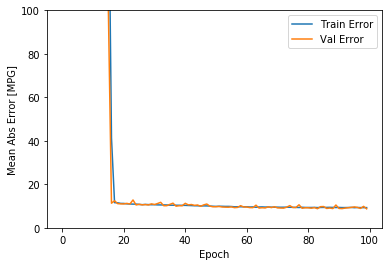

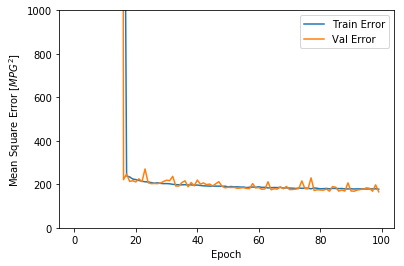

In [122]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,100])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,1000])

plot_history(history)

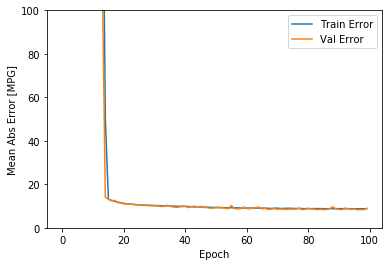

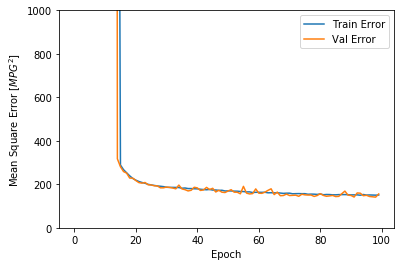

In [123]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop])

plot_history(history)

In [136]:
mean_absolute_percentage_error, mse, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("mean_absolute_percentage_error: {:5.2f}".format(mean_absolute_percentage_error))
print("MSE: {:5.2f}".format(mse))
print("MAE: {:5.2f}".format(mae))

mean_absolute_percentage_error: 168.32
MSE:  0.81
MAE: 168.32


(1113.4194111131926, 1207.6663242568532, 1135.6953214464334, 1229.942234590094)

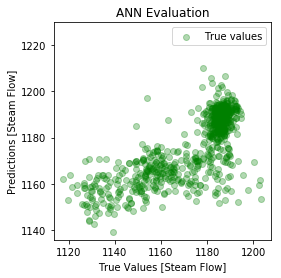

In [125]:
import matplotlib.pyplot as plt
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions, alpha = 0.3, c = 'g')
plt.title("ANN Evaluation")
plt.xlabel('True Values [Steam Flow]')
plt.ylabel('Predictions [Steam Flow]')
plt.legend(['True values', 'Predictions'], loc='upper right')
plt.axis('equal')
plt.axis('square')




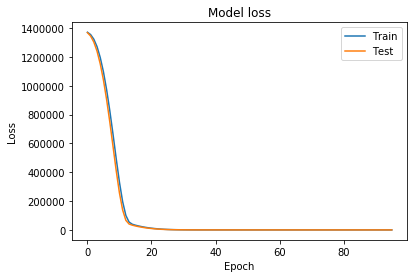

In [85]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

KeyError: ('mean_absolute_percentage_error', 'r--')

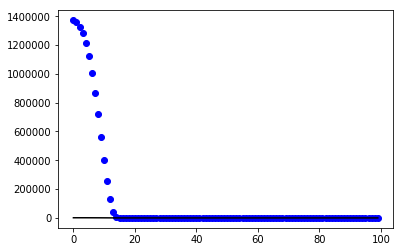

In [126]:
# plot metrics
import matplotlib.pyplot as plt
plt.plot(history.history['mean_squared_error'], 'bo')
plt.plot(history.history['mean_absolute_error'], 'k')
plt.plot(history.history['mean_absolute_percentage_error', 'r--'])
plt.show()

In [132]:
print(sum(history.history['mean_squared_error']))

11678173.345932007


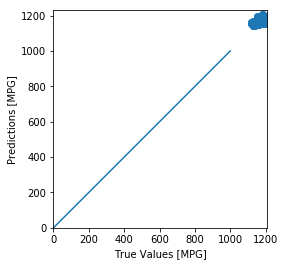

In [127]:
#Make predictions
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-1000, 1000], [-1000, 1000])

In [87]:
#-----------------------------------------------------------------------------
# Plot learning curves including R^2 and RMSE source: https://github.com/keras-team/keras/issues/7947
#-----------------------------------------------------------------------------

# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(result.history['val_r_square'])
plt.plot(result.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
           
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# print the linear regression and display datapoints
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(y_test.reshape(-1,1), y_pred)  
y_fit = regressor.predict(y_pred) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)

plt.scatter(y_test, y_pred, color='blue', label= 'data')
plt.plot(y_pred, y_fit, color='red', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Linear Regression')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

#-----------------------------------------------------------------------------
# print statistical figures of merit
#-----------------------------------------------------------------------------

import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(y_test,y_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test,y_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y_test,y_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test,y_pred))

NameError: name 'result' is not defined

In [44]:
# referência sobre métricas
#https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-2-regression-metrics-d4a1a9ba3d74

In [23]:
print(test_labels)

11      1188.355310
23      1181.591689
24      1180.650999
25      1180.522114
28      1188.099951
32      1182.280443
33      1187.886937
36      1180.432080
41      1184.432591
43      1185.154525
57      1189.040011
67      1182.422617
69      1186.471638
72      1181.361038
73      1184.231586
84      1180.148637
86      1188.932155
87      1180.792041
91      1185.799566
93      1183.902805
94      1182.950593
98      1186.878964
99      1181.464145
106     1185.578598
111     1184.704785
115     1188.332275
150     1187.651833
167     1186.294965
172     1185.325573
173     1189.565735
           ...     
1877    1184.678644
1882    1187.282715
1883    1186.374113
1884    1186.464767
1885    1185.656737
1898    1181.693226
1899    1181.470424
1913    1187.974632
1918    1188.399645
1922    1189.134788
1923    1184.651592
1934    1187.847519
1947    1186.583617
1964    1186.238955
1968    1188.422498
1971    1187.137001
1973    1186.101284
1983    1186.973999
1986    1186.617434


In [24]:
print(test_predictions)

NameError: name 'test_predictions' is not defined

In [137]:
for x, y in zip(test_labels, test_predictions):
    print("%4.3f - %4.3f" % (x,y))

1144.519 - 1165.973
1154.984 - 1167.886
1157.605 - 1167.632
1154.561 - 1165.559
1143.280 - 1166.661
1152.019 - 1170.313
1148.951 - 1160.767
1157.251 - 1158.255
1154.232 - 1161.631
1168.659 - 1160.793
1155.094 - 1171.370
1153.192 - 1168.552
1161.308 - 1166.397
1163.780 - 1167.110
1149.170 - 1166.564
1141.414 - 1169.259
1146.108 - 1169.076
1154.852 - 1167.056
1159.266 - 1166.331
1149.303 - 1170.031
1159.828 - 1170.424
1157.846 - 1162.983
1163.987 - 1164.924
1158.150 - 1163.840
1161.740 - 1162.616
1155.213 - 1164.114
1152.442 - 1158.241
1153.476 - 1165.610
1159.633 - 1163.195
1162.931 - 1161.971
1159.608 - 1159.165
1156.496 - 1161.365
1147.617 - 1157.023
1155.995 - 1165.440
1164.760 - 1164.116
1159.436 - 1164.839
1165.791 - 1162.952
1150.526 - 1158.579
1172.621 - 1159.970
1153.278 - 1164.735
1171.718 - 1159.494
1179.190 - 1162.674
1142.273 - 1157.664
1141.080 - 1160.026
1151.243 - 1159.109
1157.861 - 1161.391
1152.684 - 1161.106
1142.877 - 1164.770
1155.332 - 1166.958
1160.396 - 1164.846


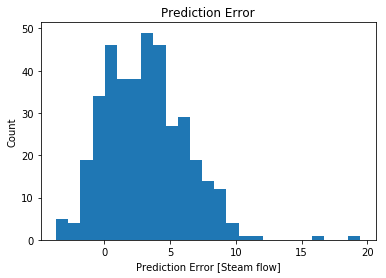

In [22]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.title("Prediction Error")
plt.xlabel("Prediction Error [Steam flow]")
_ = plt.ylabel("Count")

In [24]:
print(keras.metrics.binary_accuracy(test_labels, test_predictions))

TypeError: Input 'y' of 'Equal' Op has type float32 that does not match type float64 of argument 'x'.

In [ ]:
print(keras.metrics.categorical_accuracy(test_labels, test_predictions))
print(keras.metrics.sparse_categorical_accuracy(test_labels, test_predictions))
print(keras.metrics.top_k_categorical_accuracy(test_labels, test_predictions, k=5))
print(keras.metrics.sparse_top_k_categorical_accuracy(test_labels, test_predictions, k=5))

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.outputs

[<tf.Tensor 'dense_5/BiasAdd:0' shape=(?, 1) dtype=float32>]

In [21]:
model.inputs

[<tf.Tensor 'dense_3_input:0' shape=(?, 3) dtype=float32>]

In [22]:
model.layers

In [23]:
model.get_weights()

[array([[-2.32906997e-01,  1.45996092e-02,  6.05237298e-02,
         -6.54319227e-02, -1.52045503e-01, -2.99351841e-01,
          7.91052356e-02,  9.87614915e-02,  1.63780317e-01,
         -7.23953396e-02,  2.77105030e-02,  2.46544048e-01,
          3.51846917e-03,  5.22106662e-02,  1.04902133e-01,
         -1.06330223e-01,  9.46775079e-02,  1.72448084e-01,
         -1.32613406e-01,  1.10120550e-01,  8.41038600e-02,
         -9.49126575e-03,  1.30607396e-01,  1.19568445e-01,
          6.37942106e-02,  1.02300987e-01,  4.31615338e-02,
          1.42198816e-01,  1.82307307e-02, -2.49837607e-01,
          8.65361914e-02, -1.45921826e-01,  1.21618643e-01,
         -4.02216353e-02,  5.44415042e-02, -1.53986156e-01,
          5.20590767e-02, -1.62918121e-01,  1.24258868e-01,
         -5.76303750e-02, -2.84579843e-01,  2.79504955e-02,
         -5.24013862e-02, -1.74464136e-01, -1.37293413e-01,
          1.05878331e-01,  1.85106099e-01,  1.14184618e-01,
         -1.21507600e-01,  2.87674367e-0

In [24]:
model.save('pecem_exe.h5')

In [25]:
from keras.models import load_model
new_model = ('pecem_exe.h5')

Using TensorFlow backend.


In [26]:
model_json = model.to_json()
with open("pecem_exe.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("pecem_exe.h5")
print("Saved model to disk")

Saved model to disk
